### LSTM Hyper Parameter Tuning for Stock Data Using Keras
Name - Don Lakshitha Udara
ID - S4114011
- MSc in Financial Technology 
- Module - A.I
#### LSTM from Tensorflow tutorials 
https://www.tensorflow.org/tutorials

<img src="https://miro.medium.com/max/1400/1*lFqYLNv0L_05Flk2mJ7ZSw.png" width=600 height=400 />



#### Hyper Parameters vs Model Parameters 
Hyper parameters are used in nueral network training process and they were explicitly configured, on the other hand model parameters are internal to the model itself and normally estimated automatically.

#### Keras Tuner 

Keras tuner is a tuner offered for tensorflow machine learning applications and it can be used to pick the right combination of hyper parameters suited for the ML application.

#### Keras Tuner search models
* RandomSearch
* Hyperband
* BayesianOptimization


Lets <font color='green' >Start</font> !

In [1]:
#Importing the libraries 
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import eikon as ek
import keras_tuner as kt

#### Before we go any further lets check the version numbers just for a good measure and to avoid unexpected version related exceptions , if you are getting version related exceptions , it is recomended to setup an enviroment with following versions 

In [2]:
from platform import python_version
print ("Python version")
print (python_version())
print ("Tensorflow Version") 
print(tf.__version__)
print ("Seaborn") 
print(sns.__version__)
print ("Pandas Version") 
print(pd.__version__)
print ("Keras Version") 
print(keras.__version__)
print ("Keras Tuner Version") 
print(kt.__version__)
  

Python version
3.9.7
Tensorflow Version
2.8.0
Seaborn
0.11.2
Pandas Version
1.4.2
Keras Version
2.8.0
Keras Tuner Version
1.1.2


In [3]:
#setting up some parameters 
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 8, 4

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
RIC_LIST = ['.FTSE']
ek.set_app_key('8da94a9712004a2fab768b27a5d4aa6e062e3ec3')

2022-06-21 09:37:13,698 P[23088] [MainThread 23488] Error: no proxy address identified.
Check if Eikon Desktop or Eikon API Proxy is running.
2022-06-21 09:37:13,698 P[23088] [MainThread 23488] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2022-06-21 09:37:13,698 P[23088] [MainThread 23488] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2022-06-21 09:37:13,698 P[23088] [MainThread 23488] Port number was not identified, cannot send any request


In [4]:
# saving the Data in a file in case connectivity errors with refinitiv
if not os.path.isfile('./ftse_data_file.csv'):
 
    df = ek.get_timeseries(RIC_LIST,
                           start_date='2014-01-01',
                           end_date='2022-03-31',
                         interval='daily',)
    df.to_csv('./ftse_data_file.csv')
else:
    df = pd.read_csv('./ftse_data_file.csv',index_col='Date',parse_dates=True)

### Lets See How the data set Looks like


In [5]:
df.head()

,HIGH,CLOSE,LOW,OPEN,VOLUME
Date,,,,,
2014-01-02,6759.37,6717.91,6707.48,6749.09,459529089.0
2014-01-03,6747.33,6730.67,6699.27,6717.91,374841419.0
2014-01-06,6751.98,6730.73,6714.64,6730.67,524386927.0
2014-01-07,6768.89,6755.45,6718.07,6730.73,672375580.0
2014-01-08,6755.53,6721.78,6713.39,6755.45,720025203.0


In [6]:
df.shape

(2087, 5)

In [1]:
df.plot()

NameError: name 'df' is not defined

<AxesSubplot:ylabel='Density'>

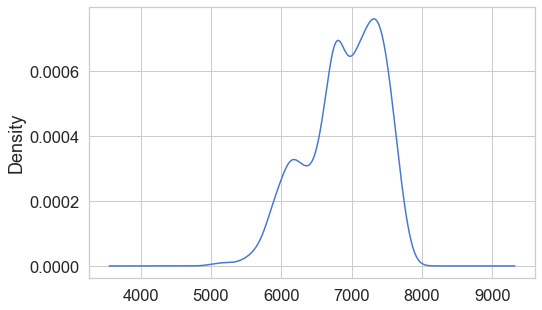

In [8]:
#Distribution of the dataset - picking the Close values only
 
df['CLOSE'].plot(kind='kde',figsize=(8, 5)) 

#### Time Series Decompose 
- Lets see the seasonality of the time series

##### Why  seasonal components important ?

In a time series data set there can be containing cycle that repeat over the time , this time period can be a constant , if its the case , then that such component is called a seasonal component and perticular component which has repeating cycles can obscure the model for forecasting,

https://www.section.io/engineering-education/time-series-decomposition-in-python/

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decompose_add = seasonal_decompose(x=df['CLOSE'], 
                                          model='additive', 
                                          period=36)
estimated_trend_add = ts_decompose_add.trend
estimated_seasonal_add = ts_decompose_add.seasonal
estimated_residual_add = ts_decompose_add.resid

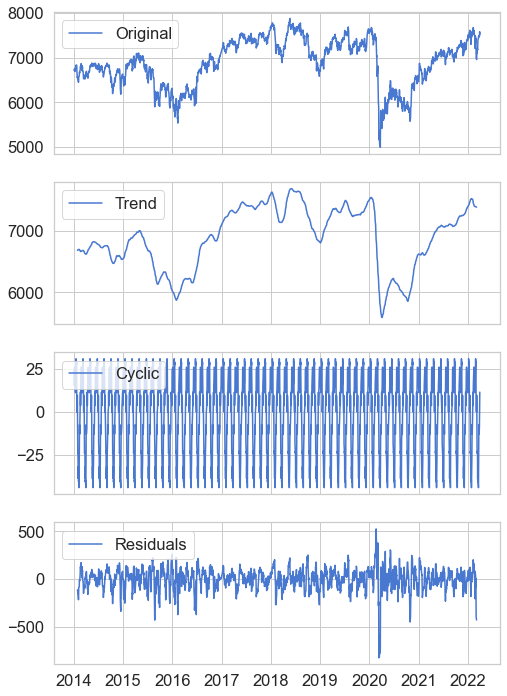

In [10]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(12)
fig.set_figwidth(8)

axes[0].plot(df['CLOSE'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend_add, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal_add, label='Cyclic')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual_add, label='Residuals')
axes[3].legend(loc='upper left');

#### Lets prepare our data set now

In [11]:
scaler = MinMaxScaler()
close_price = df.filter(['Date', 'CLOSE'])
scaler.fit(close_price)
scaled_close = scaler.transform(close_price)


In [12]:
#Taking only the close values
df = df['CLOSE'].values
df = df.reshape(-1, 1)
np.isnan(scaled_close).any() # checking nan values

False

In [13]:
trainSet = np.array(df[:int(df.shape[0]*0.8)]) # 80 : 20 rule ? read this on some paper , not sure where I got this 
testSet = np.array(df[int(df.shape[0]*0.8):])

In [14]:
scaler = MinMaxScaler(feature_range=(0,1)) # by far the easiest scalar 
trainSet = scaler.fit_transform(trainSet)
testSet = scaler.transform(testSet)

In [15]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [16]:
xTrain, yTrain = create_dataset(trainSet)
xTest, yTest = create_dataset(testSet)


In [17]:
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))



In [18]:
#Lets see the shapes 
print(  "xTrain Shape ",xTrain.shape )
print(  "yTrain Shape ",yTrain.shape )
print(  "xTest Shape ",xTest.shape )
print(  "xTest Shape ",yTest.shape )

xTrain Shape  (1619, 50, 1)
yTrain Shape  (1619,)
xTest Shape  (368, 50, 1)
xTest Shape  (368,)


#### Lets Start Hyper Parameter Tuning 

In [19]:
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from keras_tuner.tuners import Hyperband
from tensorflow.keras import layers
from keras_tuner import HyperModel
from tensorflow.keras.losses import MeanSquaredLogarithmicError
msle = MeanSquaredLogarithmicError()

#### Model

Creating a custom Hyper model class Hyper model ( normal class would be just fine )
This step is optional for the tuning, but if you are going to tune batch size and epoch size extending keras model and tuner is important since it does not support that by default

 
#### Key take away here is to understanding of the model

- Layers 

It's the number of hidden layers between input and output , and it's important to configure this carefully 
sometimes too many layers can cause your model to over fitting as well as smaller number of layers can make it under fitting.

- Number of units in a layer 

This will describe how many nodes or neuron units in a dense layer , each neuron is connected to the other neuron in the layer with densely manner and each unit of neuron responsible of receiving an input and emitting an output.

- Drop outs 

It's good practice to have an additional dropout layer in a model , because it fill tolerate the over fitting of a model. and in general, drop out layer will be aligned with the input and not with the output layer because it may cause final output calculation problems

- Learning Rate 

Learning rate indicates how fast your model can update its parameters, higher learning rate means the model can learn faster but this does not mean it will be an accurate learning, at the same time lower learning rates can be accurate in most of the times but the training process will be slow , therefore having the balance is important

-  Optimizer 

Adam optimizer will be used in this example and there are several other optimizers for keras and tensor flow 

SGD
RMSprop
Adam
Adadelta
Adagrad
Adamax
Nadam
Ftrl
refere this Keras page for more information, it's indicated in most reseaerch works that Adam is the best for time series data ( I have tried many of the optimizers in Big Data assignment and it's hard to beat Adam hence not going to test it out here )

official documentation :
https://keras.io/api/optimizers/

- Activation Function 

Activation function in this example is  relu , Activation function is what defines the output, 
please refer the keras official documentation for activation functions and get to know about sigmoid , tanh , relu , selu leaky relu , softplus , softmax....etc 

https://keras.io/api/layers/activations/

Further refer this GIT project ( which is part of the additional resources )

https://github.com/zmyzheng/Neural-Networks-and-Deep-Learning/tree/master/Improving%20Deep%20Neural%20Networks%20-%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization


In [20]:
class LSTMHyperModel(HyperModel):
    
    def build(self, hp):
      model = tf.keras.Sequential()
      model.add(LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), 
               activation='relu', input_shape=(50, 1)))  
      hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
      hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
      hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    
      model.add(Dense(units=hp_units1, activation='relu'))
      model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
      model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))
      model.add(Dense(1, kernel_initializer='normal', activation='linear'))
      model.add(keras.layers.Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1, default=0.5)))

      # Tune the learning rate for the optimizer
      # Choose an optimal value from 0.01, 0.001, or 0.0001
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
      

      model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
          loss=msle,
          metrics=[msle]
      )

      return model

### Hyperband
#### Hyperband tuning and modeling

In [21]:
hypermodel = LSTMHyperModel()

hpTuner = kt.Hyperband(
    hypermodel,
    objective='val_mean_squared_logarithmic_error',
    max_epochs=50,
    factor=3, # means 50 x3 iterations 
    directory='hyperband',
    project_name='AI'
)
# Logs will be saved in the given directort - remember when you run again it will start resume from the logs , 
# if you don't want this feature parse overwrite = True param

INFO:tensorflow:Reloading Oracle from existing project hyperband\AI\oracle.json


2022-06-21 09:37:54,032 P[23088] [MainThread 23488] Reloading Oracle from existing project hyperband\AI\oracle.json


INFO:tensorflow:Reloading Tuner from hyperband\AI\tuner0.json


2022-06-21 09:37:54,711 P[23088] [MainThread 23488] Reloading Tuner from hyperband\AI\tuner0.json


In [22]:
#un comment this if you want to use the early stopping call back
#callbacks = [tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]; 
# using this because to feed values to the tensor dashboard 
callbacks =[keras.callbacks.TensorBoard("/tmp/tb_logs")]

In [23]:
#hpTuner.search(trainX, trainY, epochs=25, validation_split=0.2,validation_data=(testX, testY))
hpTuner.search(xTrain, yTrain, epochs=25, validation_split=0.2,validation_data=(xTest, yTest),callbacks = callbacks)


INFO:tensorflow:Oracle triggered exit


2022-06-21 09:38:18,951 P[23088] [MainThread 23488] Oracle triggered exit


#### Why not loading tensor board and see the visualization of the hyper-parameer tuning , 
- once loaded look for Graphs to see the training graph
- check Time series to see the epoch loss
- check Hyper parameters on HParams
there are lot more to see , but this step is completely optional , but informative !!

In [24]:
#loading tensor board may take some time , if it's not loaded , just ignore the step 
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

Reusing TensorBoard on port 6006 (pid 33720), started 2 days, 14:28:04 ago. (Use '!kill 33720' to kill it.)

In [39]:
bestHpsHB = hpTuner.get_best_hyperparameters()[0]
print(bestHpsHB.values)



{'units': 64, 'units1': 448, 'units2': 416, 'units3': 96, 'dropout': 0.2, 'learning_rate': 0.01, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [40]:
best_hps=hpTuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units': 64,
 'units1': 448,
 'units2': 416,
 'units3': 96,
 'dropout': 0.2,
 'learning_rate': 0.01,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [27]:

hbModel= hpTuner.get_best_models()[0]

In [28]:
historyHB = hbModel.fit(xTrain, yTrain, epochs=50, batch_size=32,validation_data=(xTest, yTest))


Epoch 1/50
51/51 [==============================] - 3s 28ms/step - loss: 0.0520 - mean_squared_logarithmic_error: 0.0517 - val_loss: 0.0075 - val_mean_squared_logarithmic_error: 0.0076
Epoch 2/50
51/51 [==============================] - 1s 22ms/step - loss: 0.0562 - mean_squared_logarithmic_error: 0.0558 - val_loss: 0.0074 - val_mean_squared_logarithmic_error: 0.0076
Epoch 3/50
51/51 [==============================] - 1s 22ms/step - loss: 0.0544 - mean_squared_logarithmic_error: 0.0541 - val_loss: 0.0064 - val_mean_squared_logarithmic_error: 0.0065
Epoch 4/50
51/51 [==============================] - 1s 21ms/step - loss: 0.0575 - mean_squared_logarithmic_error: 0.0577 - val_loss: 0.0077 - val_mean_squared_logarithmic_error: 0.0078
Epoch 5/50
51/51 [==============================] - 1s 22ms/step - loss: 0.0526 - mean_squared_logarithmic_error: 0.0527 - val_loss: 0.0059 - val_mean_squared_logarithmic_error: 0.0060
Epoch 6/50
51/51 [==============================] - 1s 22ms/step - loss: 0.

In [29]:
predictionsLSTM = hbModel.predict(xTest)
predictionsLSTM = scaler.inverse_transform(predictionsLSTM)
y_test_scaled = scaler.inverse_transform(yTest.reshape(-1, 1))

In [30]:
predictionsLSTM

array([[5739.1074],
       [5718.9053],
       [5721.597 ],
       [5648.6836],
       [5651.686 ],
       [5700.188 ],
       [5658.316 ],
       [5618.5884],
       [5568.866 ],
       [5561.555 ],
       [5559.6294],
       [5581.0186],
       [5647.6978],
       [5714.4873],
       [5732.401 ],
       [5735.6636],
       [5914.622 ],
       [5997.2266],
       [6061.3833],
       [6032.506 ],
       [6015.3228],
       [6090.7866],
       [6051.832 ],
       [6066.202 ],
       [6029.341 ],
       [6041.6807],
       [6029.117 ],
       [6103.2407],
       [6072.2026],
       [6051.802 ],
       [6054.9224],
       [5981.0034],
       [6067.933 ],
       [6129.123 ],
       [6151.2896],
       [6199.26  ],
       [6203.076 ],
       [6205.9663],
       [6210.2505],
       [6238.827 ],
       [6195.939 ],
       [6184.735 ],
       [6169.724 ],
       [6216.8374],
       [6200.1245],
       [6183.188 ],
       [6092.914 ],
       [6123.5933],
       [6156.782 ],
       [6161.908 ],


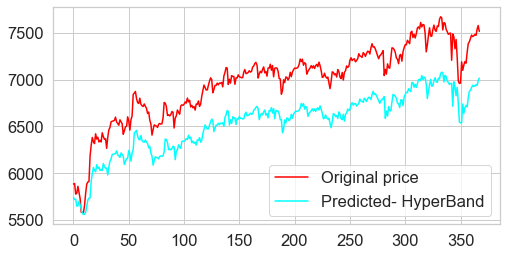

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictionsLSTM, color='cyan', label='Predicted- HyperBand')
plt.legend()

In [41]:
dtf = pd.DataFrame(y_test_scaled, columns=['Original'])
dtf['HyperBand'] =  predictionsLSTM

#### Random Search

In [42]:
randomModel = LSTMHyperModel()

randomSearchTuner = RandomSearch(
    randomModel,
    objective='val_mean_squared_logarithmic_error',
    max_trials=3,
    executions_per_trial=3,
    directory='randomSearch',
    project_name='AI')



INFO:tensorflow:Reloading Oracle from existing project randomSearch\AI\oracle.json


2022-06-21 11:18:15,407 P[23088] [MainThread 23488] Reloading Oracle from existing project randomSearch\AI\oracle.json


INFO:tensorflow:Reloading Tuner from randomSearch\AI\tuner0.json


2022-06-21 11:18:15,570 P[23088] [MainThread 23488] Reloading Tuner from randomSearch\AI\tuner0.json


In [43]:
randomSearchTuner.search(xTrain, yTrain, epochs=25, validation_split=0.1, callbacks=callbacks,validation_data=(xTest, yTest))


INFO:tensorflow:Oracle triggered exit


2022-06-21 11:18:17,516 P[23088] [MainThread 23488] Oracle triggered exit


Use Tensor Board if you need a visualization

In [35]:
#loading tensor board may take some time ,  
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 33720), started 2 days, 15:07:10 ago. (Use '!kill 33720' to kill it.)

In [44]:
bestModelRS = randomSearchTuner.get_best_models()[0]
bestModelRS.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 320)               412160    
                                                                 
 dense (Dense)               (None, 128)               41088     
                                                                 
 dense_1 (Dense)             (None, 448)               57792     
                                                                 
 dense_2 (Dense)             (None, 192)               86208     
                                                                 
 dense_3 (Dense)             (None, 1)                 193       
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 597,441
Trainable params: 597,441
Non-trai

In [45]:
besthpsRS = randomSearchTuner.get_best_hyperparameters()[0]
besthpsRS.values

{'units': 320,
 'units1': 128,
 'units2': 448,
 'units3': 192,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01}

In [46]:
historyRS = bestModelRS.fit(xTrain, yTrain, epochs=50, batch_size=32,validation_data=(xTest, yTest))


Epoch 1/50
51/51 [==============================] - 7s 114ms/step - loss: 0.0865 - mean_squared_logarithmic_error: 0.0865 - val_loss: 0.0168 - val_mean_squared_logarithmic_error: 0.0171
Epoch 2/50
51/51 [==============================] - 6s 111ms/step - loss: 0.0780 - mean_squared_logarithmic_error: 0.0779 - val_loss: 0.0172 - val_mean_squared_logarithmic_error: 0.0175
Epoch 3/50
51/51 [==============================] - 6s 110ms/step - loss: 0.0801 - mean_squared_logarithmic_error: 0.0801 - val_loss: 0.0177 - val_mean_squared_logarithmic_error: 0.0179
Epoch 4/50
51/51 [==============================] - 6s 110ms/step - loss: 0.0768 - mean_squared_logarithmic_error: 0.0766 - val_loss: 0.0146 - val_mean_squared_logarithmic_error: 0.0148
Epoch 5/50
51/51 [==============================] - 6s 112ms/step - loss: 0.0821 - mean_squared_logarithmic_error: 0.0822 - val_loss: 0.0181 - val_mean_squared_logarithmic_error: 0.0185
Epoch 6/50
51/51 [==============================] - 6s 110ms/step - lo

Epoch 45/50
51/51 [==============================] - 6s 109ms/step - loss: 0.0771 - mean_squared_logarithmic_error: 0.0767 - val_loss: 0.0173 - val_mean_squared_logarithmic_error: 0.0175
Epoch 46/50
51/51 [==============================] - 6s 109ms/step - loss: 0.0834 - mean_squared_logarithmic_error: 0.0835 - val_loss: 0.0148 - val_mean_squared_logarithmic_error: 0.0150
Epoch 47/50
51/51 [==============================] - 6s 111ms/step - loss: 0.0838 - mean_squared_logarithmic_error: 0.0838 - val_loss: 0.0192 - val_mean_squared_logarithmic_error: 0.0195
Epoch 48/50
51/51 [==============================] - 6s 110ms/step - loss: 0.0848 - mean_squared_logarithmic_error: 0.0847 - val_loss: 0.0169 - val_mean_squared_logarithmic_error: 0.0171
Epoch 49/50
51/51 [==============================] - 6s 110ms/step - loss: 0.0800 - mean_squared_logarithmic_error: 0.0800 - val_loss: 0.0155 - val_mean_squared_logarithmic_error: 0.0157
Epoch 50/50
51/51 [==============================] - 6s 112ms/ste

In [50]:
predictionsLSTMRS = bestModelRS.predict(xTest)
predictionsLSTMRS = scaler.inverse_transform(predictionsLSTMRS)
y_test_scaled = scaler.inverse_transform(yTest.reshape(-1, 1))

Lets plot the results

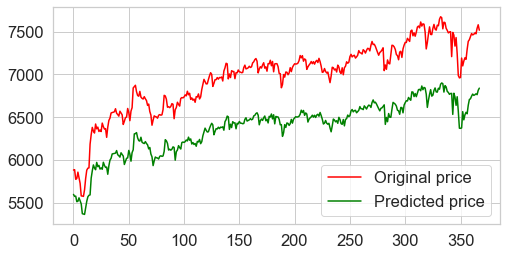

In [106]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictionsLSTMRS, color='green', label='Predicted price')
plt.legend()

In [53]:
#adding it to dft gor later use
dtf['Random Search'] =  predictionsLSTMRS
dtf.head()

,Original,HyperBand,Random Search
0,5884.65,5677.741211,5600.478516
1,5889.22,5653.200684,5577.718262
2,5776.50,5656.173340,5580.800293
3,5785.65,5585.351562,5516.075684
4,5860.28,5587.771484,5520.223145


In [55]:
randomModelB = LSTMHyperModel()

baysianTuner = kt.BayesianOptimization(
    randomModelB,
    objective='val_mean_squared_logarithmic_error',
    max_trials=3, # ( 50 epochs x 3 ) x 3
    executions_per_trial=3, # means 50 epochs x 3 
    directory='bayesian',
    project_name='AI',
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=None,)
# https://keras.io/api/keras_tuner/tuners/bayesian/

#### Bayesian Search

This may take long time to complete !!!

In [57]:
baysianTuner.search(xTrain, yTrain, epochs=50, validation_split=0.2, callbacks=callbacks,validation_data=(xTest, yTest))


Trial 3 Complete [03h 53m 35s]
val_mean_squared_logarithmic_error: 0.17029351415112615

Best val_mean_squared_logarithmic_error So Far: 0.17029351415112615
Total elapsed time: 04h 41m 42s
INFO:tensorflow:Oracle triggered exit


2022-06-19 06:27:06,816 P[36528] [MainThread 38200] Oracle triggered exit


In [58]:
bestModelB = baysianTuner.get_best_models()[0]


In [59]:
bestModelB.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1052672   
                                                                 
 dense (Dense)               (None, 96)                49248     
                                                                 
 dense_1 (Dense)             (None, 512)               49664     
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 1,414,753
Trainable params: 1,414,753
Non-

In [107]:
bestB = baysianTuner.get_best_hyperparameters()[0]
bestB.values

{'units': 512,
 'units1': 96,
 'units2': 512,
 'units3': 512,
 'dropout': 0.1,
 'learning_rate': 0.01}

In [61]:
historyBS = bestModelB.fit(xTrain, yTrain, epochs=50, batch_size=32,validation_data=(xTest, yTest))


Epoch 1/50
51/51 [==============================] - 16s 305ms/step - loss: 0.0315 - mean_squared_logarithmic_error: 0.0312 - val_loss: 0.0018 - val_mean_squared_logarithmic_error: 0.0018
Epoch 2/50
51/51 [==============================] - 16s 311ms/step - loss: 0.0323 - mean_squared_logarithmic_error: 0.0324 - val_loss: 0.0019 - val_mean_squared_logarithmic_error: 0.0020
Epoch 3/50
51/51 [==============================] - 16s 314ms/step - loss: 0.0305 - mean_squared_logarithmic_error: 0.0305 - val_loss: 0.0018 - val_mean_squared_logarithmic_error: 0.0018
Epoch 4/50
51/51 [==============================] - 16s 315ms/step - loss: 0.0262 - mean_squared_logarithmic_error: 0.0263 - val_loss: 0.0014 - val_mean_squared_logarithmic_error: 0.0014
Epoch 5/50
51/51 [==============================] - 16s 320ms/step - loss: 0.0292 - mean_squared_logarithmic_error: 0.0291 - val_loss: 0.0017 - val_mean_squared_logarithmic_error: 0.0017
Epoch 6/50
51/51 [==============================] - 16s 321ms/ste

In [62]:
predictionsLSTMB = bestModelB.predict(xTest)
predictionsLSTMB = scaler.inverse_transform(predictionsLSTMB)
y_test_scaled = scaler.inverse_transform(yTest.reshape(-1, 1))

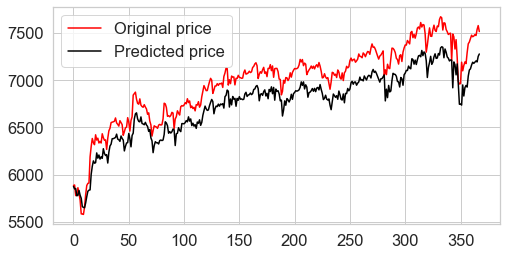

In [108]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictionsLSTMB, color='black', label='Predicted price')
plt.legend()

In [64]:
dtf['Bayesian'] =  predictionsLSTMB
dtf.head()

,Original,HyperBand,Random Search,Bayesian
0,5884.65,5677.741211,5600.478516,5873.830078
1,5889.22,5653.200684,5577.718262,5847.586426
2,5776.50,5656.173340,5580.800293,5851.396484
3,5785.65,5585.351562,5516.075684,5774.287109
4,5860.28,5587.771484,5520.223145,5780.082031


#### Now Lets evaluate the results 

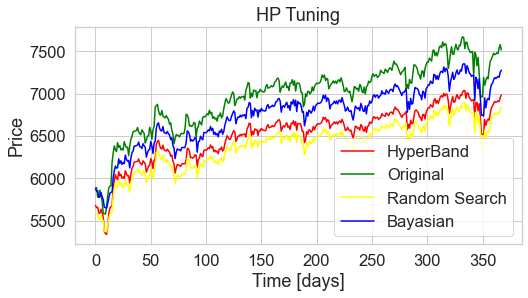

In [128]:
#lets plot all in one now
 
plt.plot(dtf['HyperBand'],label = "HyperBand", color='red') # 
plt.plot(dtf['Original'],label = "Original", color='green') # 
plt.plot(dtf['Random Search'],label = "Random Search",color='yellow') # 
plt.plot(dtf['Bayesian'],label = "Bayasian",color='blue') #


plt.title('HP Tuning')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


#### Lets make some graphs to check 


<Figure size 1280x800 with 0 Axes>

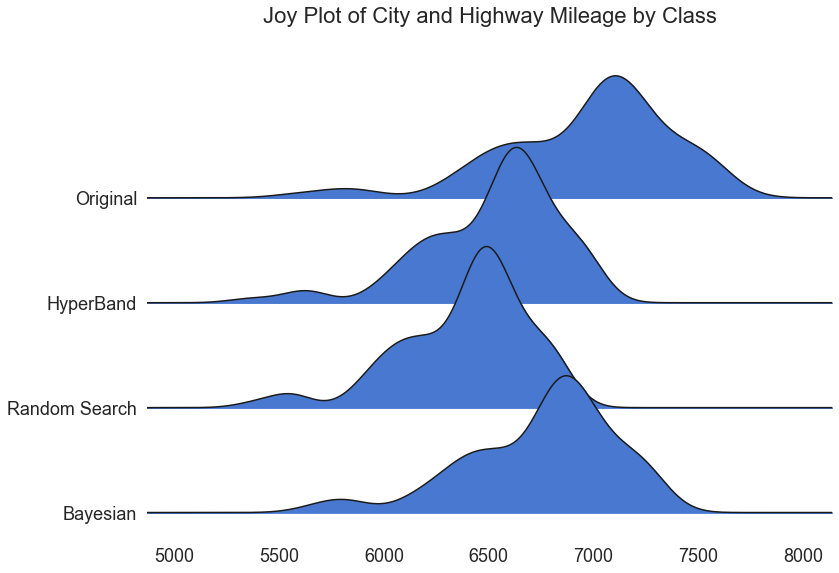

In [69]:

import joypy
mpg = dtf

# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
fig, axes = joypy.joyplot(dtf,  figsize=(12,8))

# Decoration
plt.title('Joy Plot HP tuning methods of Keras compared to the original', fontsize=22)
plt.show()

In [70]:
def createValueDF(values):
    values = [values.get("units"),
              values.get("units1"),
              values.get("units2"),
              values.get("units3"),
              values.get("dropout"),
              values.get("learning_rate")
             ]
    return values

#### Comparison of all of the hyper parameters ( best models comparison )

In [71]:
hpdf = pd.DataFrame()
hpdf['Parameter'] =  ["units","units1","units2","units3","dropout","learning_rate"]
hpdf['Hyperband'] =  createValueDF(bestHpsHB.values)
hpdf['Bayesian'] =   createValueDF(bestB.values)    
hpdf['RandomSearch'] =  createValueDF(besthpsRS.values)   
hpdf.set_index('Parameter')
hpdf

,Parameter,Hyperband,Bayesian,RandomSearch
0,units,64.00,512.00,320.00
1,units1,448.00,96.00,128.00
2,units2,416.00,512.00,448.00
3,units3,96.00,512.00,192.00
4,dropout,0.20,0.10,0.30
5,learning_rate,0.01,0.01,0.01


#### hyper parameter comparison 

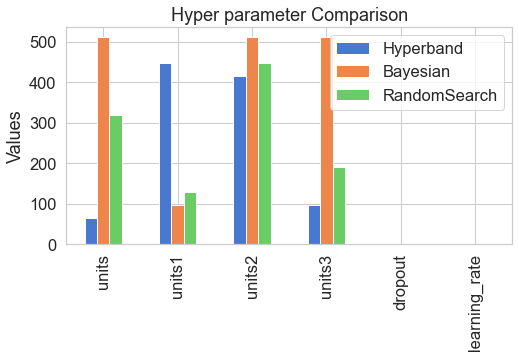

In [130]:
    from matplotlib.colors import ListedColormap
 
    ax = hpdf.plot.bar(x='Parameter')
    ax.set_xlabel(None)
    ax.set_ylabel('Values')
    ax.set_title('Hyper parameter Comparison')

    plt.show()
  


<AxesSubplot:title={'center':'Predications summary values'}>

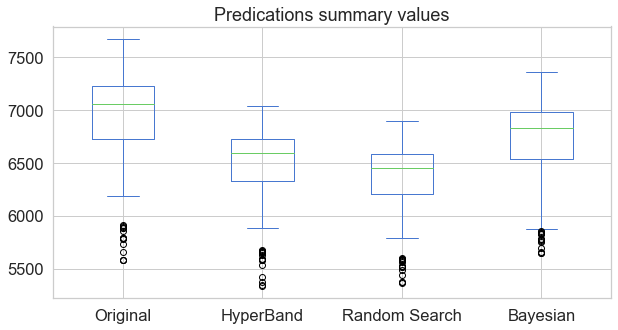

In [73]:
dtf.plot.box(figsize = (10,5), title = "Predications summary values")

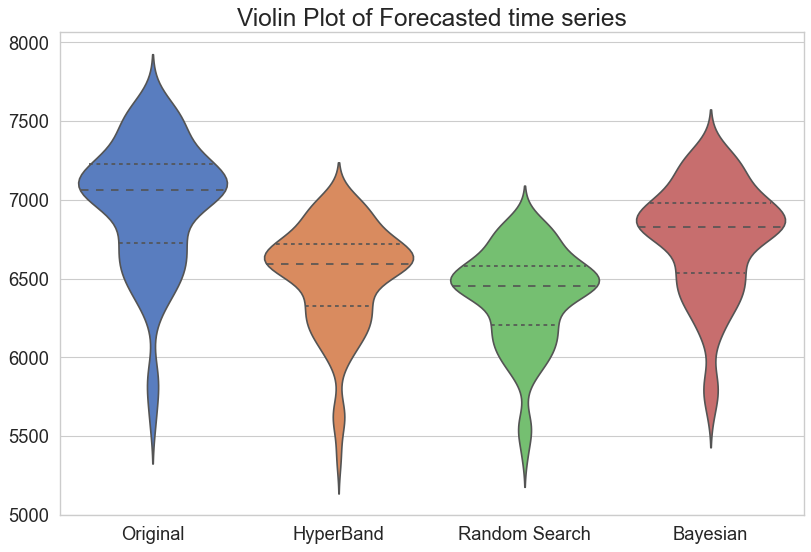

In [74]:
plt.figure(figsize=(8,4), dpi= 80)
sns.violinplot( data=dtf, scale='width', inner='quartile')

# Decoration
plt.title('Violin Plot of Forecasted time series', fontsize=22)
plt.show()

From the above two box plot and violin plot there is a clear winner isnt it ? but we have to do the it mathematically 
so lets calculate the MSE

In [129]:
from sklearn.metrics import mean_squared_error
from math import sqrt
hmse=sqrt(mean_squared_error(dtf['Original'],dtf['HyperBand']))
print(hmse)
bmse=sqrt(mean_squared_error(dtf['Original'],dtf['Bayesian']))
print(bmse)
rmse=sqrt(mean_squared_error(dtf['Original'],dtf['Random Search']))
print(rmse)
 


467.3062627438007
237.5297978895316
598.5526092952946


So Bayesian is the the best performer !! 
But there is a catch !! , Hyperband and Random search are both based on Random search , so it's not based on inteligence but based on probability , so in any given run there is a chance that one of those or both may surparse Bayesian !!
<font color='green' size='3'>Compared to what I achieved with LSTM in Big Data assignment this is just  64.5 % accuracy increasement !! </font> <font color = 'blue' size = '3' >This is why you need to tune hyper-parameters ! <font>

We do have all the model training history results saved as well , 
lets plot the value loss of all of the searchs in one 3D plot 

In [78]:
historyRS.history.keys()

dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])

In [79]:
historyHB.history.keys()


dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])

In [80]:
historyBS.history.keys()

dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])

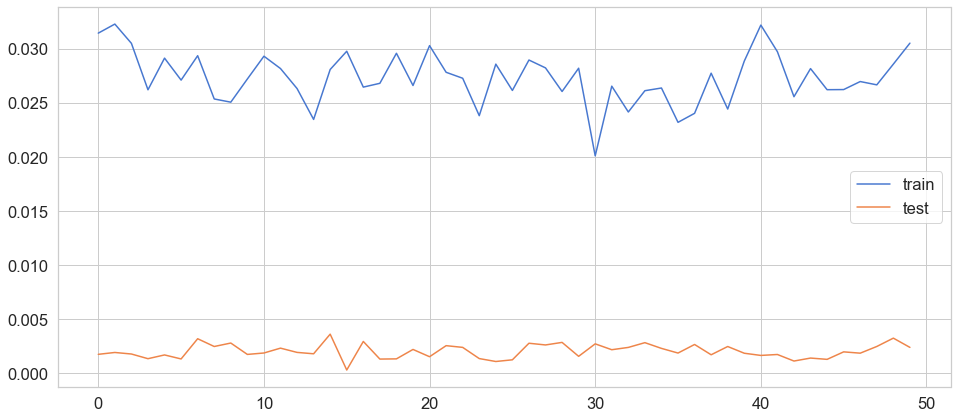

In [87]:
#Value loss of Bayesian ( best model ) , Graph is odd , I think I may have made a mistake with history values 
plt.figure(figsize=(16,7))
plt.plot(historyBS.history['loss'], label='train')

plt.plot(historyBS.history['val_loss'], label='test')
plt.legend()
plt.show()

In [89]:
lossdf = pd.DataFrame()
lossdf['Bayesian'] = historyBS.history['loss']
lossdf['Random Search'] = historyRS.history['loss']
lossdf['Hyperband'] = historyHB.history['loss']

In [90]:
lossdf

,Bayesian,Random Search,Hyperband
0,0.031464,0.087108,0.057117
1,0.032302,0.080698,0.055432
2,0.030521,0.080201,0.051545
3,0.026228,0.083181,0.047345
4,0.029154,0.076353,0.052485
5,0.027123,0.076326,0.051658
6,0.029377,0.078315,0.054700
7,0.025379,0.082265,0.049268
8,0.025082,0.079627,0.052674
9,0.027224,0.082743,0.052098


In [97]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(lossdf, x='Bayesian', y='Random Search', z='Hyperband',
              color=list(range(0, 50)), size=list(range(0, 50)), size_max=18,
                opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# 4D graph where color represent the epochs from 0-50 
# can see that in each epoch Bayesian is doing good for example 
at Epoch 47 - b - 0.02 ,rs = 0.07 ,hb = 0.05


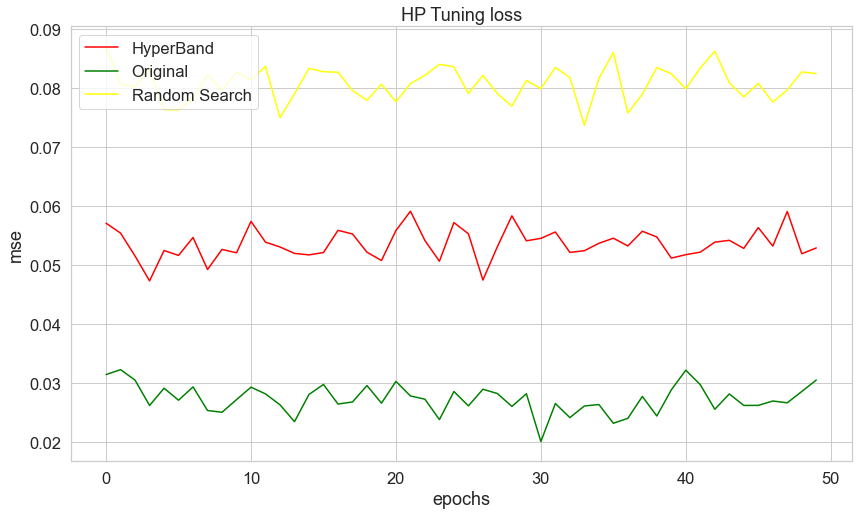

In [101]:
 #lets plot all in one now
#plt.plot(fit_1.fittedvalues, label = "HyperBand" ,color='Green') #.8
#plt.plot(fit_2.fittedvalues, label = "Random Search	",color='Red') # .6 
plt.plot(lossdf['Hyperband'],label = "HyperBand", color='red') # 
plt.plot(lossdf['Bayesian'],label = "Original", color='green') # 
plt.plot(lossdf['Random Search'],label = "Random Search",color='yellow') # 
 

plt.title('HP Tuning loss')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend(loc='best')

#### Loading the tensor board for Bayesian

In [132]:
#loading tensor board may take some time ,  
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 33720), started 21:02:05 ago. (Use '!kill 33720' to kill it.)

## All the Search algorithems did well

#### Result 
- Bayesian is the key take away with best tuned HPs,
- Hyperband and Random Search are based on probability so any given day they might beat or equal Bayesian
- In Conclusion it can be derrived that for FTSE stock price time series forecasting with LSTM , Bayesian is the best HP optimizer 


#### Future Work
- Improve this work by tuning Epochs and batch sizes 
- check about how hyper parameters related to each other
- develop a custom search function 


#### Some good tutorials which helped to build this code

- 50 best mat-plot graphs for python 
https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#49.-Andrews-Curve
- Time series data analysis ( they have their own plot library for python )
https://www.aptech.com/blog/introduction-to-the-fundamentals-of-time-series-data-and-analysis/
    Gauss tutorials 
    https://docs.aptech.com/gauss/plotts.html